# Learn the RT stage. 

Given $u$, solve the following LP:

$\min_{y, f} y^TQy$

s.t. $0\leq y\leq \bar{y}$

$-\bar{f}\leq f\leq \bar{f}$

$y+\tilde{B}f\geq u$

Note that the input to the NN is u, and the output is (y, f).

Here, f is of dimension N-1, i.e., f is the set of fundamental flows.

Unstable training is observed.

Possible reasons:


*   Learn the set of edge flows instead. (not help)
*   Update the analytic center of the feasible set for every new batch of u. (not help)
* Find out why the training loss is oscillating, and set the f in v0 (the strictly feasible point) to be zero. (not help)

* Normalize y and f such that they are comparable in both upper and lower bounds and values. (not help)



# Parameters


*   $N$: number of buses, i.e., $N=14$
*   $L$: $L=N-1$, i.e., number of fundamental flows
*   $m$: number of edges, i.e., $m=20$

*   $\tilde{B}$: $\tilde{B}=B^TK\in\mathbb{R}^{N\times L}$, which transforms the set of fundamental flows to all edge flows
*   $\beta$: cost vector
*   $R = np.diag(beta.flatten())$


In [ ]:
from torch import linalg as LA

sample_size = 10000
test_size = 100

u_trn = np.random.uniform(-0.1, 0.1, (sample_size, N))
u_tst = np.random.uniform(-0.1, 0.1, (test_size, N))

np.save(saved_path+'u_trn.npy', u_trn)
np.save(saved_path+'u_tst.npy', u_tst)

f_max = 10 # to tighten, make it much smaller, for example, 0.5
y_max = 10

assert L == N-1, "Incorrect number of fundamental flows."
G = np.block([
            [-np.eye(N),        np.zeros((N, L))],
            [np.eye(N),         np.zeros((N, L))],
            [np.zeros((L, N)),  -np.eye(L)],
            [np.zeros((L, N)),  np.eye(L)],
            [-y_max*np.eye(N),        -f_max*B_tilde]
])
print('shape of G:', G.shape)
 
p = G.shape[0]
q = G.shape[1]
k = sample_size


u_trn_mean = u_trn.mean(axis=0).reshape(-1, 1)
print('u_trn_mean:', u_trn_mean.shape)

u_tst_mean = u_tst.mean(axis=0).reshape(-1, 1)
# print('u_tst_mean:', u_tst_mean)


# Define the feasible set using the mean right hand vector
# Define the feasible set Gv<=h
h1 = np.zeros((N, 1))
h2 = np.ones((N, 1))
h3 = np.ones((L, 1))
h4 = np.ones((L, 1))
h5 = -u_trn_mean
h = np.concatenate([h1, h2, h3, h4, h5], axis=0)
print('h:', h.shape)

shape of G: (68, 27)
u_trn_mean: (14, 1)
h: (68, 1)


# Find the analytic center of this feasible set $P=\{v:Gv\leq h\}$, or, $P=\{v:g_i^Tv\leq h_i, i=1,\cdots,m\}$ by solving the following LP:

$\max_{V_C, r}$ r

s.t. $g_i^TV_C + r\|g_i\|_2\leq h_i, i=1,\cdots,m$

In [ ]:
## Define and solve the above LP to find the analytic center of the feasible set
r = cp.Variable()
Vc = cp.Variable(N+L)

constraints_list = []
for i in range(p):
    constraints_list.append( G[i,:]*Vc+r*cp.norm(G[i,:], 2)<=h[i,0])

prob = cp.Problem(cp.Maximize(r), constraints_list)

result =  prob.solve()
# print('problem.status:', prob.status)

print('r:', r.value)
print('Vc:', Vc.value)
print('prob.value:', prob.value)

r: 0.2564876421421128
Vc: [ 0.63090596  0.74351236  0.74351236  0.74351236  0.74351236  0.74351236
  0.74351236  0.74351236  0.74351236  0.74351236  0.74351236  0.74351236
  0.74351236  0.74351236  0.74351236 -0.28757866 -0.1809085  -0.08621085
 -0.31736721 -0.18901761 -0.49606976 -0.38075211 -0.10242173  0.0597453
  0.19685738 -0.11967873 -0.35896924]
prob.value: 0.2564876421421128


Training starts!
[50/5001], loss: 0.04669
[100/10001], loss: 0.00038
[150/15001], loss: 0.00021
[200/20001], loss: 0.00011
[250/25001], loss: 0.00009
[300/30001], loss: 0.00010
[350/35001], loss: 0.00009
[400/40001], loss: 0.00007
[450/45001], loss: 0.00006
[500/50001], loss: 0.00651
[550/55001], loss: 0.00006
[600/60001], loss: 0.00009
[650/65001], loss: 0.00006
[700/70001], loss: 0.00006
[750/75001], loss: 0.00005
[800/80001], loss: 0.00005
[850/85001], loss: 0.00006
[900/90001], loss: 0.00007
[950/95001], loss: 0.00005
[1000/100001], loss: 0.00005
[1050/105001], loss: 0.00005
[1100/110001], loss: 0.00143
[1150/115001], loss: 0.00005
[1200/120001], loss: 0.00008
[1250/125001], loss: 0.00005
[1300/130001], loss: 0.00005
[1350/135001], loss: 0.00004
[1400/140001], loss: 0.00005
[1450/145001], loss: 0.00004
[1500/150001], loss: 0.00004
[1550/155001], loss: 0.00005
[1600/160001], loss: 0.00019
[1650/165001], loss: 0.00019
[1700/170001], loss: 0.00005
[1750/175001], loss: 0.00035
[1800/18

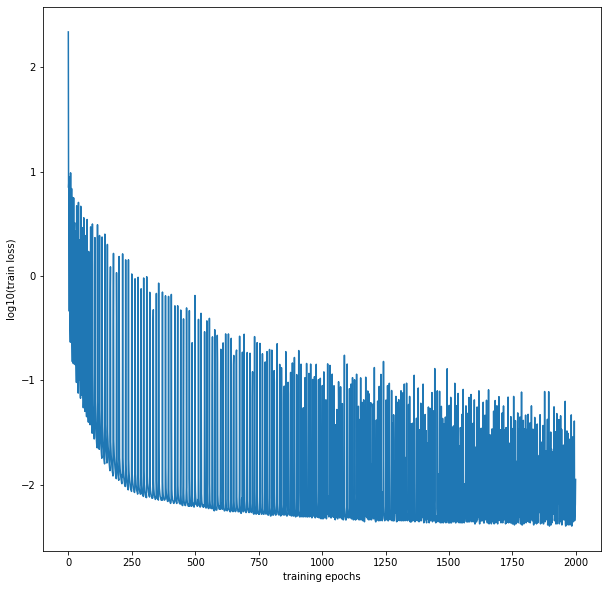

In [ ]:
lr = 0.0005
random.seed(123123)

# Build a NN just for the second stage problem
D_in = N
H = 100
D_out = q
NN_y = tanhNet(D_in, H, D_out)

# Initialize
NN_y.apply(init_weights)

# Adam optimizer
optim_y = optim.Adam(NN_y.parameters(), lr=lr, betas=(0.5, 0.999))


def gauge_function(V, G, H):
    """
    The gauge function of the vector z w.r.t. the set P
    is given by the following code.

    V can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    
    """

    # torch.div() for element-wide division
    return torch.max(torch.div(G@V, H),dim = 0).values # shape(output) = (1, K)

def gauge_map(Z, G, H):
    """
    For any Z \belongsto B_infinity, the gauge map from B_infinity to the set P
    defined by {v: G@v <= h} is given by the following code.
    
    Z can be batched, for example, r-dimensional and batch size of K, then shape(V) = (r, K)
    Note that the second dimension is the batch.

    P is defined by {v: G@v <= Hj} = {v: g_i^T@v <= Hj_i, i = 1, ..., q}
    shape(G) = (q, r), shape(Hj) = (q, 1), shape(H) = (q, K)
    P must contain the origin in its interior.
    """

    gamma_dest = gauge_function(Z, G, H)
    gamma_start = torch.linalg.norm(Z, ord = np.inf, dim=0) # shape(1, K)

    scaling_mat = torch.diag(gamma_start/gamma_dest) # shape = (K, K)

    return Z@scaling_mat # shape = (r, K), this is the new point in P


def train(NN_y, Vc, num_epochs, batch_size, yplot = 'plain'):

    G_ts = torch.tensor(G).float()
    B_ts = torch.tensor(B_tilde).float()

    Q_ts = torch.tensor(Q).float()
    R_ts = torch.tensor(R).float()

    Vc_ts = torch.tensor(Vc).float().reshape(-1, 1)
    
    # Sampling load
    u_trn = np.load(saved_path+'u_trn.npy')
    dataset = RiskDataset(u_trn)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    train_hist = {}
    train_hist['train_losses'] = []
    train_hist['per_epoch_time'] = []
    train_hist['total_time'] = []
    num_iter = 0

    print('Training starts!')
    start_time = time.time()

    for epoch in range(num_epochs):
        train_losses = []
        epoch_start_time = time.time()

        for batch in train_loader:
            # update net
            NN_y.zero_grad()
            U_m = batch.float()

            # Feed into NN_y
            Z_m =  NN_y(U_m).T 

            # Define the feasible set Gv<=H_m
            NB = Z_m.shape[-1]
            h1 = torch.zeros(N, NB)
            h2 = torch.ones(N, NB)
            h3 = torch.ones(L, NB)
            h4 = torch.ones(L, NB)
            h5 = -U_m.T
            H_m = torch.cat([h1, h2, h3, h4, h5], dim=0)

            # Construct a strictly feasible point v0 using the analytic center of the polytope
            # The polytope is defined using the mean value of the right-hand-side vector u
            v0 = Vc_ts.repeat((1, NB)) # repeat 1 time along axis0 and NB times along axis1

            # Check if v0 is a feasible point
            assert torch.max(G_ts@v0 - H_m)< 0.0, "Caution: v0 is not a feasible point."

            # Use v0 to shift the feasible set Gv<=H
            H_tilde = H_m - G_ts@v0
            assert torch.min(H_tilde) > 0.0, "Caution: origin is not an interior point"

            # Use gauge mapping to transform Z_m to Z_tilde_m
            Z_tilde_m = gauge_map(Z_m, G_ts, H_tilde) + v0
            # print('Z_tilde_m:', Z_tilde_m.shape)

            Y_m = Z_tilde_m[:N,:]

            # Calculate loss function L(\theta_x, \theta_y)
            obj_func = torch.diagonal(Y_m.T@R_ts@Y_m/2, 0)
            train_loss = torch.mean(obj_func, 0) 

            train_loss.backward(retain_graph=True)
            optim_y.step()
            

            train_losses.append(train_loss.item())

            num_iter += 1

            if num_iter % 5000 == 0:
                print('[%d/%d], loss: %.5f' % ((epoch + 1), 
                    (num_iter + 1), 
                    torch.FloatTensor(train_losses).mean().item()))
                
                # print('v0:', v0.detach().numpy()[:,:2])
                # print('Z_m:', Z_m.detach().numpy()[:,:2])
                # print('Y_m:', Y_m.detach().numpy()[:,:2])
                
        epoch_end_time = time.time()
        per_epoch_time = epoch_end_time - epoch_start_time

        loss_value = torch.mean(torch.FloatTensor(train_losses)).item()
        # Keep in mind that the true cost should be scaled up
        loss_value = y_max*y_max*loss_value

        train_hist['train_losses'].append(round(loss_value, 4))
        train_hist['per_epoch_time'].append(per_epoch_time)
                
    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Avg per epoch time: %.2f, total %d epochs time: %.2f" % \
        (torch.mean(torch.FloatTensor(train_hist['per_epoch_time'])), num_epochs, total_time))
    print("Training finish!")

    print(len(train_hist['train_losses']))

    # End training loop
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    if yplot == 'log10':
        ax.plot(range(len(train_hist['train_losses'])), np.log10(train_hist['train_losses']), label='train loss')
        ax.set_ylabel('log10(train loss)')
    elif yplot == 'plain':
        ax.plot(range(len(train_hist['train_losses'])), train_hist['train_losses'], label='train loss')
        ax.set_ylabel('train loss')
    ax.set_xlabel('training epochs')
    # ax.set_xticks(range(len(train_hist['train_losses'])))
    plt.savefig(saved_path+'train_losses.png')

    return NN_y

trained_NN_y = train(NN_y, Vc.value, num_epochs = 2000, batch_size = 100, yplot = 'log10')

